In [2]:
#python绘图
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

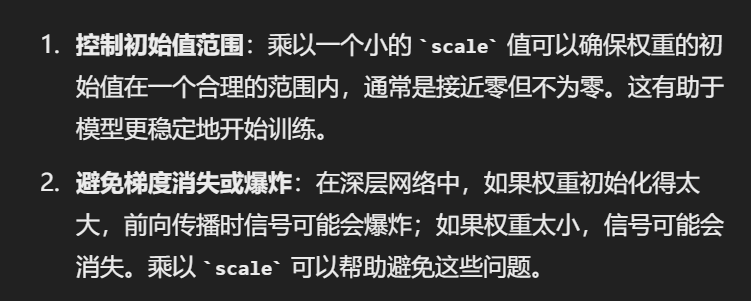

In [3]:
#对一个LeNet网络进行简单修改得到 简单网络
# 初始化模型参数
# 初始化权重时乘以 scale 的原因是为了控制权重值的范围，
# 使其不至于过大或者过小，从而避免梯度消失或爆炸的问题
scale = 0.01

# 第一层卷积层的权重和偏置，大小为(20, 1, 3, 3)
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)

# 第二层卷积层的权重和偏置，大小为(50, 20, 5, 5)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)

# 第三层全连接层的权重和偏置，大小为(800, 128)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)

# 第四层全连接层的权重和偏置，大小为(128, 10)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)

# 将所有参数存储在一个列表中
params = [W1, b1, W2, b2, W3, b3, W4, b4]

In [6]:
# 定义LeNet模型
def lenet(X, params):
    # 第一层卷积层，使用参数params[0]（权重）和params[1]（偏置）
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    # 应用ReLU激活函数
    h1_activation = F.relu(h1_conv)
    # 应用平均池化层，窗口大小为2x2，步幅为2x2
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))

    # 第二层卷积层，使用参数params[2]（权重）和params[3]（偏置）
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    # 应用ReLU激活函数
    h2_activation = F.relu(h2_conv)
    # 应用平均池化层，窗口大小为2x2，步幅为2x2
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))

    # 将输出展平为二维张量，以便输入到全连接层
    h2 = h2.reshape(h2.shape[0], -1)

    # 第三层全连接层，使用参数params[4]（权重）和params[5]（偏置）
    h3_linear = torch.mm(h2, params[4]) + params[5]
    # 应用ReLU激活函数
    h3 = F.relu(h3_linear)

    # 输出层，使用参数params[6]（权重）和params[7]（偏置）
    y_hat = torch.mm(h3, params[6]) + params[7]

    return y_hat


In [7]:
# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [9]:
def get_params(params, device):
    # 将参数移动到指定的设备（例如 GPU）
    new_params = [p.to(device).to(device) for p in params]
    # 设置参数需要计算梯度
    for p in new_params:
        p.requires_grad_()
    # 返回在设备上的新参数
    return new_params

In [11]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 权重:', new_params[1])
#还没有对梯度做计算 所以得到的梯度为none
print('b1 梯度:', new_params[1].grad)

b1 权重: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 梯度: None


In [14]:
def allreduce(data):
    # 循环遍历 data 列表的每个元素（从第二个开始），并将其加到第一个元素上
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    # 将第一个元素的值同步到 data 列表的每个其他元素上
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

In [15]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


In [17]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0)]
output: (tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:0'),)


In [18]:
#@save
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

In [19]:
def train_batch(X, y, device_params, devices, lr):
    # 将数据 X 和标签 y 分割成多个设备（如多个 GPU）上的小批量
    X_shards, y_shards = split_batch(X, y, devices)
    
    # 在每个 GPU 上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    
    # 在每个 GPU 上分别执行反向传播
    for l in ls:
        l.backward()
    
    # 将每个 GPU 的所有梯度相加，并将其广播到所有 GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))])
    
    # 在每个 GPU 上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])  # 在这里，我们使用全尺寸的小批量

In [22]:
def train(num_gpus, batch_size, lr):
#     num_gpus: 使用的GPU数量。
#     batch_size: 批处理大小。
#     lr: 学习率。

    # 加载Fashion-MNIST数据集
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    
    # 获取用于训练的设备列表，通常是多个GPU
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    
    # 将模型参数复制到多个GPU上
    device_params = [get_params(params, d) for d in devices]
    
    # 定义训练的轮数
    num_epochs = 10
    
    # 初始化动画器，用于显示训练过程中的测试精度
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    
    # 初始化计时器
    timer = d2l.Timer()
    
    # 开始训练
    for epoch in range(num_epochs):
        timer.start()
        
        # 遍历训练数据集中的每个批次
        for X, y in train_iter:
            # 在每个批次上执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()  # 同步所有GPU
        
        timer.stop()
        
        # 在GPU 0上评估模型的测试精度
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    
    # 输出最终的测试精度和平均训练时间
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

测试精度：0.85，3.6秒/轮，在[device(type='cuda', index=0)]


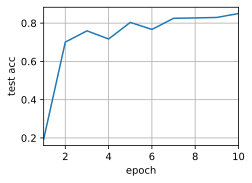

In [23]:
#单个GPU
train(num_gpus=1, batch_size=256, lr=0.2)

测试精度：0.80，3.7秒/轮，在[device(type='cuda', index=0)]


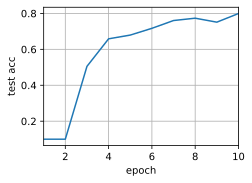

In [24]:
train(num_gpus=1, batch_size=256*2, lr=0.2)

In [26]:
# 多GPU的简洁
import torch
from torch import nn
from d2l import torch as d2l

In [27]:
#@save
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    
    # 定义一个生成残差块的函数
    def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                # 如果不是第一个残差块且是第一个残差单元，需要用1x1卷积调整通道数
                blk.append(d2l.Residual(in_channels, out_channels, use_1x1conv=True, strides=2))
            else:
                # 否则只改变通道数不改变尺寸
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大池化层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    # 添加四个残差块
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    
    # 添加全局平均池化层
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    
    # 添加全连接层用于分类
    net.add_module("fc", nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, num_classes)
    ))
    
    return net


In [28]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 我们将在训练代码实现中初始化网络

In [29]:
net

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_block2): Sequential(
   

In [30]:
devices

[device(type='cuda', index=0)]

In [33]:
# nn.DataParallel(net, device_ids=devices) 函数是 PyTorch 中用于实现模型并行的工具
# 它可以将一个模型在多个 GPU 上运行，每个 GPU 处理数据的不同部分
# 最后将每个 GPU 的梯度相加并更新模型参数

In [31]:
def train(net, num_gpus, batch_size, lr):
    # 加载 Fashion MNIST 数据集
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    # 获取指定数量的 GPU 设备
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    
    # 初始化网络权重
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    
    # 在多个 GPU 上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    
    # 定义优化器和损失函数
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    
    timer, num_epochs = d2l.Timer(), 10  # 定义计时器和训练轮数
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])  # 定义绘图器
    
    for epoch in range(num_epochs):
        net.train()  # 设定模型为训练模式
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()  # 梯度清零
            X, y = X.to(devices[0]), y.to(devices[0])  # 将数据移动到设备
            l = loss(net(X), y)  # 计算损失
            l.backward()  # 反向传播
            trainer.step()  # 更新参数
        timer.stop()
        
        # 在测试集上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    
    # 打印最终的测试精度和每轮训练的平均时间
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，在{str(devices)}')

测试精度：0.92，27.6秒/轮，在[device(type='cuda', index=0)]


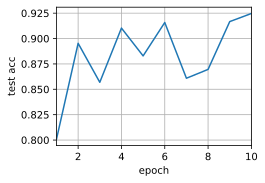

In [32]:
#在单个GPU上进行训练
train(net, num_gpus=1, batch_size=256, lr=0.1)

测试精度：0.83，28.1秒/轮，在[device(type='cuda', index=0)]


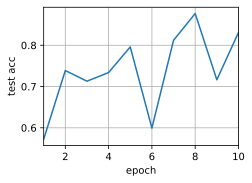

In [34]:
train(net, num_gpus=1, batch_size=256*2, lr=0.1*2)

In [36]:
# 神经网络可以在（可找到数据的）单GPU上进行自动评估。

# 每台设备上的网络需要先初始化，然后再尝试访问该设备上的参数，否则会遇到错误。

# 优化算法在多个GPU上自动聚合。